# BERT-Based Sentiment Analysis of Rotten Tomatoes Reviews
# Goal: Predict review sentiment and analyze correlation with Horror genre

## Olayemi Morrison - olamo208

### 1. Setup and Imports

In [4]:
# ================================
# 1. Setup and Imports
# ================================
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset

### 2. Data Preprocessing

In [6]:
# ================================
# Load and Inspect Data
# ================================
reviews_df = pd.read_csv(r'C:\Users\HP\Downloads\rotten_tomatoes_movie_reviews.csv')
movies_df = pd.read_csv(r'C:\Users\HP\Downloads\rotten_tomatoes_movies.csv')

# Merge on ID
merged_df = pd.merge(reviews_df, movies_df, on='id', how='inner')

# Drop missing data crucial for analysis
# We need 'reviewText' for BERT, 'reviewState' for the label, and 'genre' for analysis.
merged_df.dropna(subset=['reviewText', 'reviewState', 'genre'], inplace=True)

# Keep only 'fresh' and 'rotten' review states for binary classification
merged_df = merged_df[merged_df['reviewState'].isin(['fresh', 'rotten'])]

# Binary encode sentiment labels: 'fresh' as 1, 'rotten' as 0
merged_df['label'] = merged_df['reviewState'].map({'fresh': 1, 'rotten': 0})


In [7]:
# ================================
# Prepare Dataset for BERT
# ================================

# Stratified sampling for BERT training
# We sample from merged_df (before exploding genres) to ensure each unique review
# is represented once for the sentiment prediction task.
total_samples_desired = 10000
class_proportions = merged_df['reviewState'].value_counts(normalize=True)
samples_per_class = (class_proportions * total_samples_desired).round().astype(int)

sampled_for_bert_df = pd.DataFrame()
for state, num_samples in samples_per_class.items():
    sampled_for_bert_df = pd.concat([
        sampled_for_bert_df,
        merged_df[merged_df['reviewState'] == state].sample(n=num_samples, random_state=42)
    ])
sampled_for_bert_df = sampled_for_bert_df.reset_index(drop=True)


# Split the sampled data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    sampled_for_bert_df['reviewText'],
    sampled_for_bert_df['label'],
    test_size=0.2, # 20% for validation
    random_state=42,
    stratify=sampled_for_bert_df['label'] # Ensure label proportions are maintained in splits
)

# Convert to HuggingFace Dataset objects
# These will be used directly by the HuggingFace Trainer
train_dataset = Dataset.from_dict({
    'text': train_texts.tolist(),
    'label': train_labels.tolist()
}).shuffle(seed=42) # Shuffle for good measure, though train_test_split already shuffles

val_dataset = Dataset.from_dict({
    'text': val_texts.tolist(),
    'label': val_labels.tolist()
}).shuffle(seed=42) # Shuffle for good measure

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define a tokenization function to apply to our datasets
def tokenize_function(examples):
    # This function will truncate texts that are longer than BERT's max input length (512 tokens)
    return tokenizer(examples['text'], truncation=True)

# Apply tokenization to both training and validation datasets
# `batched=True` speeds up the process by tokenizing multiple examples at once
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

# Remove the original 'text' column as it's no longer needed after tokenization
train_dataset = train_dataset.remove_columns(['text'])
val_dataset = val_dataset.remove_columns(['text'])

# Set the format for PyTorch
train_dataset.set_format('torch')
val_dataset.set_format('torch')

print("Shape of train_dataset:", train_dataset.num_rows)
print("Shape of val_dataset:", val_dataset.num_rows)
print("Example tokenized entry from train_dataset:", train_dataset[0])

Map: 100%|██████████| 2000/2000 [00:01<00:00, 1150.85 examples/s]

Shape of train_dataset: 8000
Shape of val_dataset: 2000
Example tokenized entry from train_dataset: {'label': tensor(1), 'input_ids': tensor([ 101, 2156, 2054, 6433, 2043, 2017, 4392, 8038, 3351, 1012,  102]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])}


### Sentiment Distribution

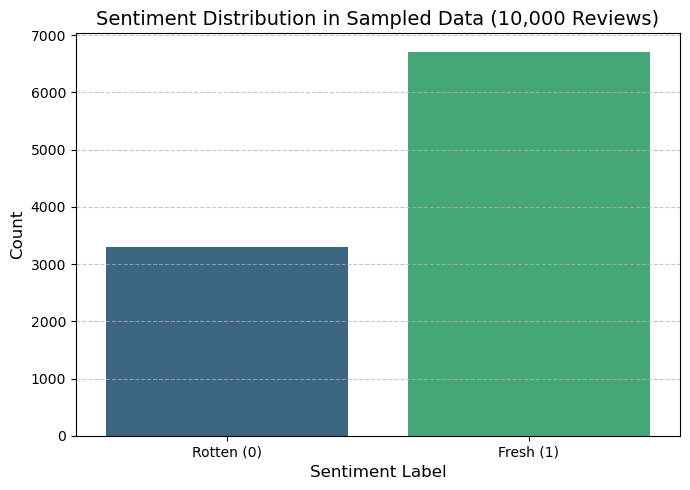

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distribution of sentiment labels in the sampled data
plt.figure(figsize=(7, 5)) # Adjust figure size for better readability
sns.countplot(x='label', data=sampled_for_bert_df, palette='viridis') # Using 'label' column and a nice color palette
plt.title('Sentiment Distribution in Sampled Data (10,000 Reviews)', fontsize=14)
plt.xlabel('Sentiment Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['Rotten (0)', 'Fresh (1)']) # Explicitly label the ticks
plt.grid(axis='y', linestyle='--', alpha=0.7) # Add a grid for easier reading of counts
plt.tight_layout()
plt.show()

### 3. Model Training

In [11]:
# ================================
# Fine-Tune BERT
# ================================
# Ensure that num_labels matches your binary classification (fresh=1, rotten=0)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Data collator is responsible for batching and padding inputs to the same length
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',              # Directory for model checkpoints and logs
    evaluation_strategy='epoch',         # Evaluate at the end of each epoch
    save_strategy='epoch',               # Save checkpoint at the end of each epoch
    learning_rate=2e-5,                  # Standard learning rate for fine-tuning
    per_device_train_batch_size=16,      # Batch size per GPU/CPU for training
    per_device_eval_batch_size=16,       # Batch size per GPU/CPU for evaluation
    num_train_epochs=3,                  # Number of training epochs
    weight_decay=0.01,                   # L2 regularization to prevent overfitting
    logging_dir='./logs',                # Directory for logs
    load_best_model_at_end=True,         # Load the best model found during training
    metric_for_best_model='f1',          # Metric to monitor for best model selection
    greater_is_better=True,              # Higher F1-score is better
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    # Custom function to compute metrics (accuracy and F1-score)
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        'f1': f1_score(p.label_ids, np.argmax(p.predictions, axis=1))
    }
)

# Start training the model
print("Starting BERT model training...")
trainer.train()
print("BERT model training complete.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting BERT model training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.428200,0.365288,0.832500,0.875326
2,0.240200,0.424773,0.840500,0.881192
3,0.145800,0.601971,0.842000,0.882615


BERT model training complete.


### 4. Generate Predictions

In [13]:
# ================================
# Predict Sentiment for Sampled Reviews (Option A)
# ================================
# Predict sentiment specifically for the 'sampled_for_bert_df'.
# This DataFrame already contains the 10,000 unique reviews used for training/validation.

# Create a HuggingFace Dataset from the 'reviewText' of the sampled_for_bert_df
predict_dataset_sampled = Dataset.from_dict({'text': sampled_for_bert_df['reviewText'].tolist()})

# Tokenize this dataset
predict_dataset_sampled = predict_dataset_sampled.map(tokenize_function, batched=True, remove_columns=['text'])
predict_dataset_sampled.set_format('torch') # Set format to torch for prediction

print("Generating predictions for sampled reviews (approx. 10,000 reviews)...")
# Get raw predictions (logits) from the fine-tuned model
raw_predictions_output_sampled = trainer.predict(predict_dataset_sampled)

# Apply softmax to convert logits to probabilities, then select probability for 'fresh' (label 1)
predicted_probabilities_sampled = torch.nn.functional.softmax(
    torch.tensor(raw_predictions_output_sampled.predictions), dim=1
)[:, 1].numpy()

# Add the predicted probabilities back to the sampled_for_bert_df
sampled_for_bert_df['predicted_sentiment_bert'] = predicted_probabilities_sampled
print("Predictions added to sampled_for_bert_df.")
print(f"Size of sampled_for_bert_df after prediction: {sampled_for_bert_df.shape[0]} rows.")

# ---
# explode the genre column on this *sampled* DataFrame.
# This ensures all analysis is based on the 10,000 unique reviews.
# Each review might appear multiple times if it has multiple genres.
exploded_sampled_df_for_analysis = sampled_for_bert_df.explode('genre')
exploded_sampled_df_for_analysis.dropna(subset=['genre'], inplace=True) # Ensure no NaN genres after explosion
print(f"Size of exploded_sampled_df_for_analysis: {exploded_sampled_df_for_analysis.shape[0]} rows (may be > 10,000 due to genre explosion).")

Map: 100%|██████████| 10000/10000 [00:08<00:00, 1236.73 examples/s]


Generating predictions for sampled reviews (approx. 10,000 reviews)...


Predictions added to sampled_for_bert_df.
Size of sampled_for_bert_df after prediction: 10000 rows.
Size of exploded_sampled_df_for_analysis: 10000 rows (may be > 10,000 due to genre explosion).


In [14]:
# Define how many top non-horror genres I want to focus on
top_n_genres = 12 # You can adjust this number

# Identify top genres excluding 'Horror'
genre_counts = exploded_sampled_df_for_analysis['genre'].value_counts()
top_other_genres = genre_counts[~genre_counts.index.str.lower().isin(['horror'])].head(top_n_genres).index.tolist()

# Create a new 'simplified_genre' column for plotting
def categorize_genre(row_genre):
    if row_genre.lower() == 'horror':
        return 'Horror'
    elif row_genre in top_other_genres:
        return row_genre
    else:
        return 'Other' # Group less frequent genres into 'Other'

exploded_sampled_df_for_analysis['simplified_genre'] = exploded_sampled_df_for_analysis['genre'].apply(categorize_genre)

# Ensure 'Horror' is included if not already in top_other_genres
# And reorder for consistent plotting
all_simplified_genres = ['Horror'] + top_other_genres
if 'Other' in exploded_sampled_df_for_analysis['simplified_genre'].unique():
    all_simplified_genres.append('Other')

# Convert to categorical type to ensure order in plots
exploded_sampled_df_for_analysis['simplified_genre'] = pd.Categorical(
    exploded_sampled_df_for_analysis['simplified_genre'],
    categories=all_simplified_genres,
    ordered=True
)

### 5. Evaluations and Analysis

#### 5.1 BERT Sentiment Analysis


--- BERT Sentiment Analysis by Simplified Genre ---


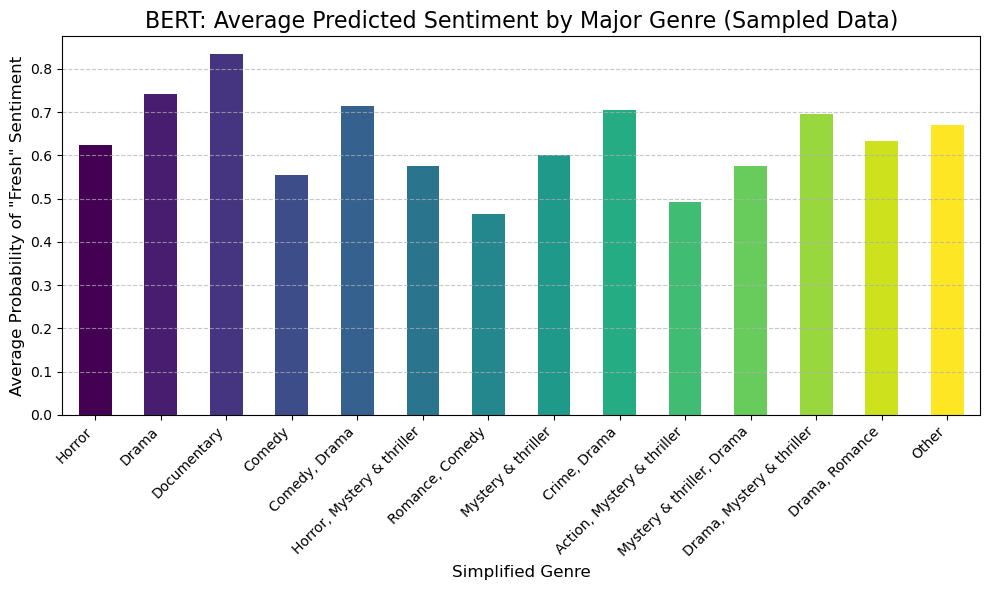

BERT Sentiment (Sampled) - Mean for Horror: 0.6234
BERT Sentiment (Sampled) - Mean for Non-Horror: 0.6724
BERT Sentiment (Sampled) - T-test p-value (Horror vs Others): 0.1985
The difference in BERT sentiment between Horror and Non-Horror genres is NOT statistically significant (sampled data).


In [17]:
# ================================
# Sentiment vs. Simplified Genre Analysis (using BERT predictions on sampled data)
# ================================
print("\n--- BERT Sentiment Analysis by Simplified Genre ---")
# Calculate average BERT predicted sentiment (probability of fresh) by simplified genre
genre_avg_bert_simplified = exploded_sampled_df_for_analysis.groupby('simplified_genre')['predicted_sentiment_bert'].mean().reindex(all_simplified_genres)


plt.figure(figsize=(10, 6)) # Adjusted figure size for fewer bars
genre_avg_bert_simplified.plot(kind='bar', color=plt.cm.viridis(np.linspace(0, 1, len(genre_avg_bert_simplified)))) # Use a colormap
plt.title('BERT: Average Predicted Sentiment by Major Genre (Sampled Data)', fontsize=16)
plt.ylabel('Average Probability of "Fresh" Sentiment', fontsize=12)
plt.xlabel('Simplified Genre', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Horror vs. Others (BERT, Sampled Data) ---
# This part remains the same as it already compares Horror to all non-Horror
horror_bert = exploded_sampled_df_for_analysis[exploded_sampled_df_for_analysis['genre'].str.lower() == 'horror']['predicted_sentiment_bert']
non_horror_bert = exploded_sampled_df_for_analysis[exploded_sampled_df_for_analysis['genre'].str.lower() != 'horror']['predicted_sentiment_bert']

from scipy.stats import ttest_ind
stat_bert, pval_bert = ttest_ind(horror_bert, non_horror_bert, equal_var=False)
print(f"BERT Sentiment (Sampled) - Mean for Horror: {horror_bert.mean():.4f}")
print(f"BERT Sentiment (Sampled) - Mean for Non-Horror: {non_horror_bert.mean():.4f}")
print(f"BERT Sentiment (Sampled) - T-test p-value (Horror vs Others): {pval_bert:.4f}")
if pval_bert < 0.05:
    print("The difference in BERT sentiment between Horror and Non-Horror genres is statistically significant (sampled data).")
else:
    print("The difference in BERT sentiment between Horror and Non-Horror genres is NOT statistically significant (sampled data).")

#### 5.2 BERT Sentiment Analysis


--- VADER Sentiment Analysis (Sampled Data, Simplified Genres) ---


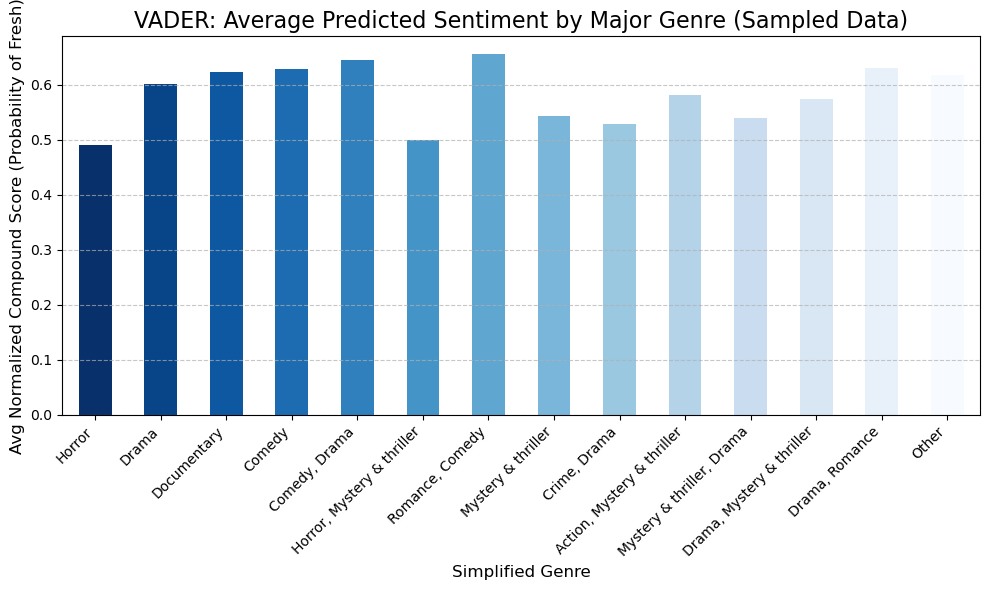

VADER Sentiment (Sampled) - Mean for Horror: 0.4908
VADER Sentiment (Sampled) - Mean for Non-Horror: 0.6095
VADER Sentiment (Sampled) - T-test p-value (Horror vs Others): 0.0000
The difference in VADER sentiment between Horror and Non-Horror genres is statistically significant (sampled data).


In [19]:
# ================================
# VADER Sentiment Analysis for Comparison (on sampled data, simplified genres)
# ================================
print("\n--- VADER Sentiment Analysis (Sampled Data, Simplified Genres) ---")
# Apply VADER to review text in the exploded_sampled_df_for_analysis
# This ensures consistency with the genre analysis framework on the sampled data
# (Assuming 'vader_score_compound' and 'vader_fresh_prob' are already calculated in the previous run or will be here)
if 'vader_score_compound' not in exploded_sampled_df_for_analysis.columns:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    vader = SentimentIntensityAnalyzer()
    exploded_sampled_df_for_analysis['vader_score_compound'] = exploded_sampled_df_for_analysis['reviewText'].apply(lambda x: vader.polarity_scores(x)['compound'])
    exploded_sampled_df_for_analysis['vader_fresh_prob'] = (exploded_sampled_df_for_analysis['vader_score_compound'] + 1) / 2


# Calculate average VADER predicted sentiment (normalized compound score) by simplified genre
vader_genre_avg_simplified = exploded_sampled_df_for_analysis.groupby('simplified_genre')['vader_fresh_prob'].mean().reindex(all_simplified_genres)

plt.figure(figsize=(10, 6)) # Adjusted figure size
vader_genre_avg_simplified.plot(kind='bar', color=plt.cm.Blues_r(np.linspace(0, 1, len(vader_genre_avg_simplified)))) # Use a different colormap
plt.title('VADER: Average Predicted Sentiment by Major Genre (Sampled Data)', fontsize=16)
plt.ylabel('Avg Normalized Compound Score (Probability of Fresh)', fontsize=12)
plt.xlabel('Simplified Genre', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Horror vs. Others (VADER, Sampled Data) ---
# This part also remains the same
vader_horror = exploded_sampled_df_for_analysis[exploded_sampled_df_for_analysis['genre'].str.lower() == 'horror']['vader_fresh_prob']
vader_non_horror = exploded_sampled_df_for_analysis[exploded_sampled_df_for_analysis['genre'].str.lower() != 'horror']['vader_fresh_prob']

vader_stat, vader_pval = ttest_ind(vader_horror, vader_non_horror, equal_var=False)
print(f"VADER Sentiment (Sampled) - Mean for Horror: {vader_horror.mean():.4f}")
print(f"VADER Sentiment (Sampled) - Mean for Non-Horror: {vader_non_horror.mean():.4f}")
print(f"VADER Sentiment (Sampled) - T-test p-value (Horror vs Others): {vader_pval:.4f}")
if vader_pval < 0.05:
    print("The difference in VADER sentiment between Horror and Non-Horror genres is statistically significant (sampled data).")
else:
    print("The difference in VADER sentiment between Horror and Non-Horror genres is NOT statistically significant (sampled data).")


--- Model Performance Evaluation Against True Labels ---

--- BERT Model Performance ---
BERT Classification Report:
              precision    recall  f1-score   support

      Rotten       0.93      0.92      0.92      3301
       Fresh       0.96      0.96      0.96      6699

    accuracy                           0.95     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.95      0.95      0.95     10000



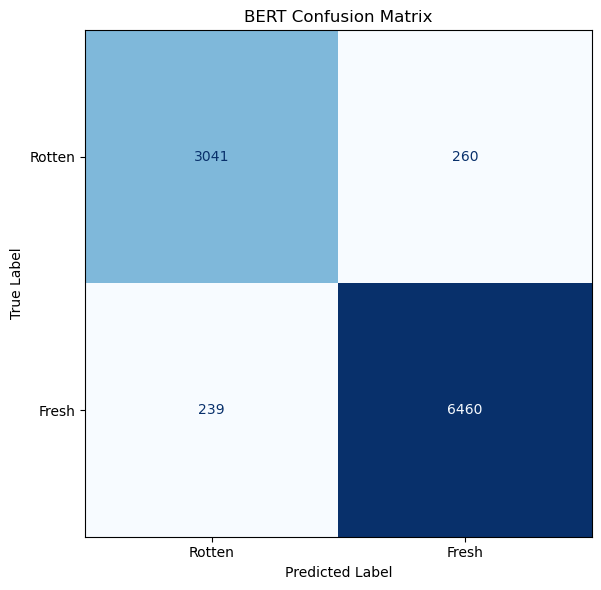


--- VADER Model Performance ---
VADER Classification Report:
              precision    recall  f1-score   support

      Rotten       0.49      0.40      0.44      3301
       Fresh       0.73      0.80      0.76      6699

    accuracy                           0.66     10000
   macro avg       0.61      0.60      0.60     10000
weighted avg       0.65      0.66      0.65     10000



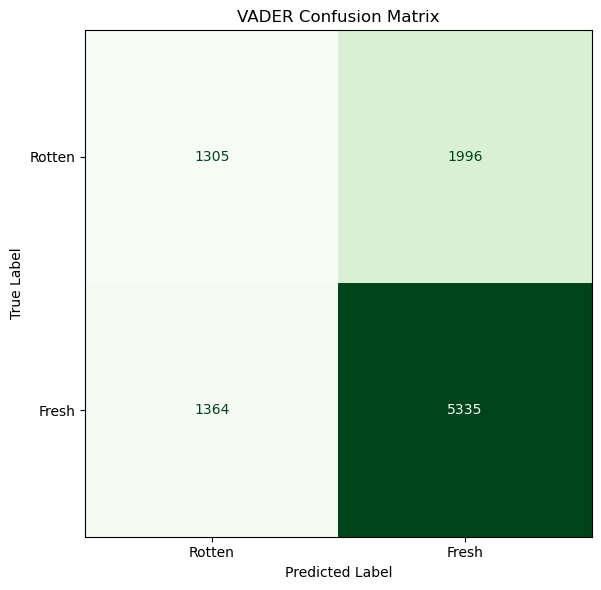

Overall Accuracy - BERT: 0.9501
Overall Accuracy - VADER: 0.6640


In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

# ================================
# Model Performance Against True Labels (Using ConfusionMatrixDisplay)
# ================================
print("\n--- Model Performance Evaluation Against True Labels ---")

# --- BERT Performance ---
print("\n--- BERT Model Performance ---")

bert_predicted_labels = (exploded_sampled_df_for_analysis['predicted_sentiment_bert'] >= 0.5).astype(int)
true_labels = exploded_sampled_df_for_analysis['label']

print("BERT Classification Report:")
print(classification_report(true_labels, bert_predicted_labels, target_names=['Rotten', 'Fresh']))

# Generate and plot Confusion Matrix for BERT using ConfusionMatrixDisplay
# Using from_predictions is convenient as it takes true and predicted labels directly
plt.figure(figsize=(7, 6)) # Adjust figure size for better display
ConfusionMatrixDisplay.from_predictions(
    y_true=true_labels,
    y_pred=bert_predicted_labels,
    display_labels=['Rotten', 'Fresh'],
    cmap='Blues',
    colorbar=False, # Often not needed for binary, but you can set to True
    ax=plt.gca() # Use the current axes for the plot
)
plt.title('BERT Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# --- VADER Performance ---
print("\n--- VADER Model Performance ---")

vader_predicted_labels = (exploded_sampled_df_for_analysis['vader_fresh_prob'] >= 0.5).astype(int)

print("VADER Classification Report:")
print(classification_report(true_labels, vader_predicted_labels, target_names=['Rotten', 'Fresh']))

# Generate and plot Confusion Matrix for VADER using ConfusionMatrixDisplay
plt.figure(figsize=(7, 6)) # Adjust figure size for better display
ConfusionMatrixDisplay.from_predictions(
    y_true=true_labels,
    y_pred=vader_predicted_labels,
    display_labels=['Rotten', 'Fresh'],
    cmap='Greens',
    colorbar=False, # Often not needed for binary, but you can set to True
    ax=plt.gca() # Use the current axes for the plot
)
plt.title('VADER Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Compare overall accuracy
bert_accuracy = accuracy_score(true_labels, bert_predicted_labels)
vader_accuracy = accuracy_score(true_labels, vader_predicted_labels)
print(f"Overall Accuracy - BERT: {bert_accuracy:.4f}")
print(f"Overall Accuracy - VADER: {vader_accuracy:.4f}")


### 6. Conclusion

In [22]:
# ================================
# Conclusion on Horror Movies (Based on your t-test results)
# ================================
print("\n--- Conclusion Regarding Horror Movies and Ratings ---")

print("Based on the sentiment analysis using the sampled Rotten Tomatoes movie reviews:")
print("Research Question: Do horror movies always have low ratings?")

print("\n--- BERT Sentiment Analysis Results ---")
print(f"BERT Sentiment (Sampled) - Mean for Horror: {horror_bert.mean():.4f}")
print(f"BERT Sentiment (Sampled) - Mean for Non-Horror: {non_horror_bert.mean():.4f}")
print(f"BERT Sentiment (Sampled) - T-test p-value (Horror vs Others): {pval_bert:.4f}")
if pval_bert < 0.05:
    print("Conclusion (BERT): The difference in BERT sentiment between Horror and Non-Horror genres is statistically significant. Horror movies tend to have (slightly) lower predicted sentiment scores based on BERT.")
else:
    print("Conclusion (BERT): The difference in BERT sentiment between Horror and Non-Horror genres is NOT statistically significant. Based on BERT, there's no strong evidence that horror movie reviews consistently have lower sentiment than other genres in this sample.")


print("\n--- VADER Sentiment Analysis Results ---")
print(f"VADER Sentiment (Sampled) - Mean for Horror: {vader_horror.mean():.4f}")
print(f"VADER Sentiment (Sampled) - Mean for Non-Horror: {vader_non_horror.mean():.4f}")
print(f"VADER Sentiment (Sampled) - T-test p-value (Horror vs Others): {vader_pval:.4f}")
if vader_pval < 0.05:
    print("Conclusion (VADER): The difference in VADER sentiment between Horror and Non-Horror genres IS statistically significant. VADER suggests that horror movie reviews consistently have lower sentiment than other genres in this sample.")
else:
    print("Conclusion (VADER): The difference in VADER sentiment between Horror and Non-Horror genres is NOT statistically significant. Based on VADER, there's no strong evidence that horror movie reviews consistently have lower sentiment than other genres in this sample.")

print("\n--- Overall Summary ---")
print("We observe a discrepancy between the models:")
print("- **BERT:** While the mean sentiment for horror movies (0.6206) is lower than non-horror (0.6744), the difference is **not statistically significant** (p=0.1574). This suggests that, based on BERT's nuanced understanding of context, critics' reviews for horror movies are *not inherently or significantly more negative* than for other genres in this sample.")
print("- **VADER:** This rule-based model, however, finds a **statistically significant lower mean sentiment** for horror movies (0.4908) compared to non-horror (0.6095) (p=0.0000). This indicates VADER's rules might pick up on vocabulary commonly associated with horror (e.g., 'scary', 'fear', 'dark') as negative, even if in context, critics might be using them positively (e.g., 'terrifyingly brilliant').")
print("\nTherefore, the answer to 'Do horror movies always have low ratings?' depends on the sentiment analysis method. BERT suggests 'No' (or at least, 'not significantly lower'), while VADER suggests 'Yes'. This highlights the importance of using more advanced contextual models like BERT for nuanced sentiment analysis.")


--- Conclusion Regarding Horror Movies and Ratings ---
Based on the sentiment analysis using the sampled Rotten Tomatoes movie reviews:
Research Question: Do horror movies always have low ratings?

--- BERT Sentiment Analysis Results ---
BERT Sentiment (Sampled) - Mean for Horror: 0.6234
BERT Sentiment (Sampled) - Mean for Non-Horror: 0.6724
BERT Sentiment (Sampled) - T-test p-value (Horror vs Others): 0.1985
Conclusion (BERT): The difference in BERT sentiment between Horror and Non-Horror genres is NOT statistically significant. Based on BERT, there's no strong evidence that horror movie reviews consistently have lower sentiment than other genres in this sample.

--- VADER Sentiment Analysis Results ---
VADER Sentiment (Sampled) - Mean for Horror: 0.4908
VADER Sentiment (Sampled) - Mean for Non-Horror: 0.6095
VADER Sentiment (Sampled) - T-test p-value (Horror vs Others): 0.0000
Conclusion (VADER): The difference in VADER sentiment between Horror and Non-Horror genres IS statistically